In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import h5py

In [2]:
# Simulate Synthetic User Data
np.random.seed(42)

In [3]:
data = {
    "Score": np.random.randint(0, 1000, 1000),
    "TimeTaken": np.random.randint(20, 300, 1000),
    "HealthLost": np.random.randint(0, 1000, 1000),
    "LevelNo": np.random.randint(1, 21, 1000),
    "LevelDifficulty": np.random.uniform(0, 1, 1000),
}

In [4]:
df = pd.DataFrame(data)

In [5]:
# Function to Create Sequential Data for RNN
def create_sequences(df, sequence_length=3):
    sequences = []
    targets = []
    for i in range(len(df) - sequence_length):
        # Use the last `sequence_length` rows as a sequence
        seq = df.iloc[i:i + sequence_length, :-1].values
        target = df.iloc[i + sequence_length, -1]  # Difficulty of the next level
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [6]:
# Prepare Input and Target
sequence_length = 3
inputs, targets = create_sequences(df, sequence_length)

In [7]:
# Normalize the Inputs
scaler = MinMaxScaler()
inputs = scaler.fit_transform(inputs.reshape(-1, inputs.shape[-1])).reshape(inputs.shape)
targets = targets.reshape(-1, 1)  # Reshape for consistency

In [8]:
# Convert to Tensors
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

In [9]:
# Dataset and DataLoader
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
# Define the RNN Model
class DifficultyPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DifficultyPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # Only use the last hidden state
        hn = hn[-1]  # Get the hidden state from the last LSTM layer
        out = self.fc(hn)  # Fully connected layer
        return out

In [11]:
# Initialize Model, Loss Function, and Optimizer
input_size = inputs.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1

In [12]:
model = DifficultyPredictor(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
# Training Loop
epochs = 5500
train_losses = []

In [14]:
for epoch in range(epochs):
    epoch_loss = 0.0
    model.train()
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(dataloader))
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

Epoch [10/5500], Loss: 0.0847
Epoch [20/5500], Loss: 0.0846
Epoch [30/5500], Loss: 0.0849
Epoch [40/5500], Loss: 0.0826
Epoch [50/5500], Loss: 0.0851
Epoch [60/5500], Loss: 0.0834
Epoch [70/5500], Loss: 0.0841
Epoch [80/5500], Loss: 0.0817
Epoch [90/5500], Loss: 0.0826
Epoch [100/5500], Loss: 0.0824
Epoch [110/5500], Loss: 0.0842
Epoch [120/5500], Loss: 0.0846
Epoch [130/5500], Loss: 0.0825
Epoch [140/5500], Loss: 0.0835
Epoch [150/5500], Loss: 0.0822
Epoch [160/5500], Loss: 0.0828
Epoch [170/5500], Loss: 0.0852
Epoch [180/5500], Loss: 0.0817
Epoch [190/5500], Loss: 0.0829
Epoch [200/5500], Loss: 0.0830
Epoch [210/5500], Loss: 0.0806
Epoch [220/5500], Loss: 0.0832
Epoch [230/5500], Loss: 0.0821
Epoch [240/5500], Loss: 0.0816
Epoch [250/5500], Loss: 0.0808
Epoch [260/5500], Loss: 0.0823
Epoch [270/5500], Loss: 0.0828
Epoch [280/5500], Loss: 0.0821
Epoch [290/5500], Loss: 0.0811
Epoch [300/5500], Loss: 0.0829
Epoch [310/5500], Loss: 0.0830
Epoch [320/5500], Loss: 0.0826
Epoch [330/5500],

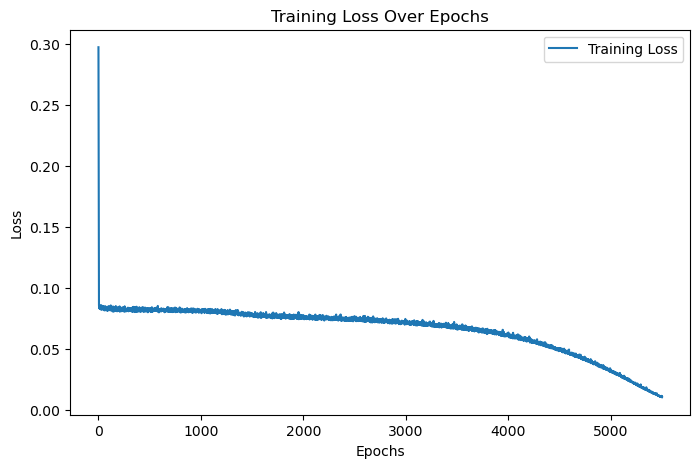

In [15]:
# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [16]:
# Test Data (Using 20% of the original dataset)
split_idx = int(0.8 * len(inputs))
test_inputs, test_targets = inputs[split_idx:], targets[split_idx:]
test_dataset = TensorDataset(test_inputs, test_targets)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
# Evaluate Model Performance
def evaluate_model(model, dataloader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            outputs = model(batch_inputs)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(batch_targets.squeeze().tolist())
    return predictions, actuals

In [18]:
# Evaluate and Visualize Predictions vs Actuals
predictions, actuals = evaluate_model(model, test_loader)

### Visualizations

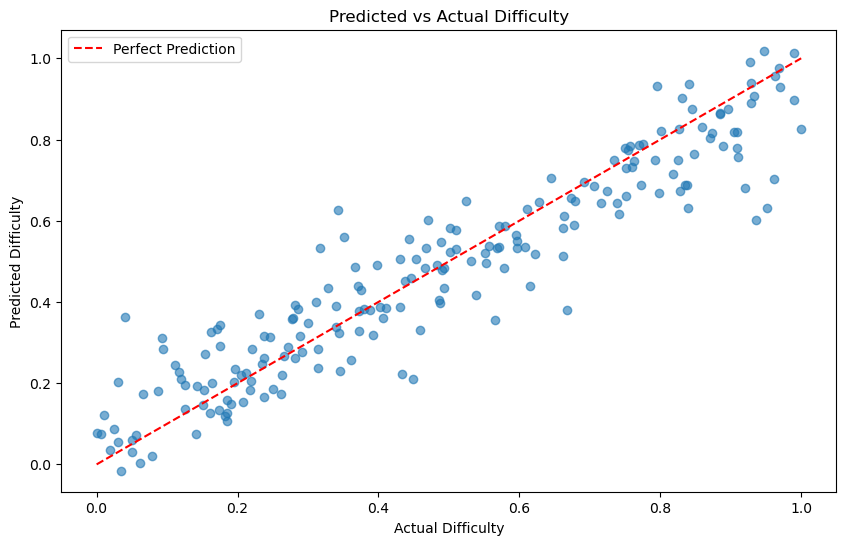

In [19]:
# 1. Predicted vs Actual Difficulty
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], "r--", label="Perfect Prediction")
plt.xlabel("Actual Difficulty")
plt.ylabel("Predicted Difficulty")
plt.title("Predicted vs Actual Difficulty")
plt.legend()
plt.show()

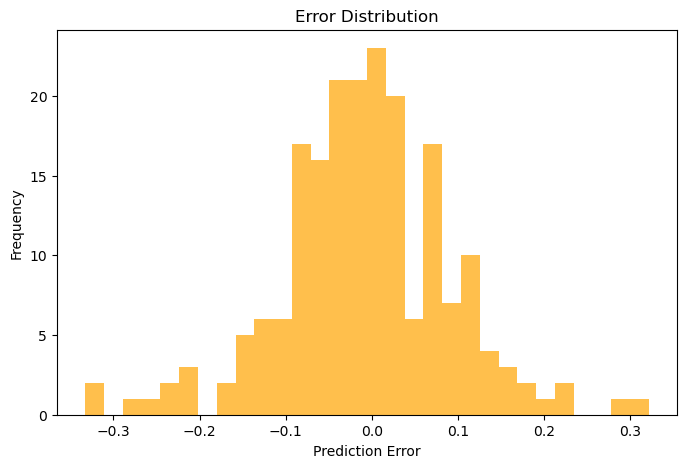

In [20]:
# 2. Error Distribution
errors = np.array(predictions) - np.array(actuals)
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=30, alpha=0.7, color="orange")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.show()

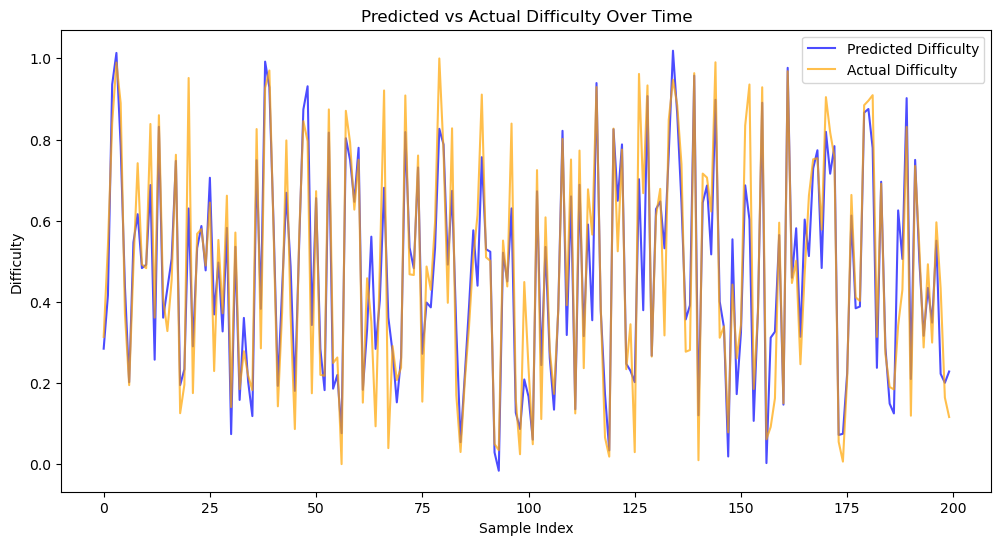

In [21]:
# 3. Predicted and Actual Difficulty History
plt.figure(figsize=(12, 6))
plt.plot(predictions, label="Predicted Difficulty", color="blue", alpha=0.7)
plt.plot(actuals, label="Actual Difficulty", color="orange", alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Difficulty")
plt.title("Predicted vs Actual Difficulty Over Time")
plt.legend()
plt.show()

In [22]:
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
rmse = np.sqrt(mse)

In [23]:
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 0.0100
Mean Absolute Error (MAE): 0.0744
R-squared (R2): 0.8774
Root Mean Squared Error (RMSE): 0.0999


In [24]:
# Save Model as model.h5
def save_model_as_h5(model, filepath):
    model.eval()
    with h5py.File(filepath, "w") as h5file:
        for name, param in model.named_parameters():
            h5file.create_dataset(name, data=param.detach().numpy())

In [25]:
save_model_as_h5(model, "difficulty_predictor_model.h5")
print("Model saved as 'difficulty_predictor_model.h5'")

Model saved as 'difficulty_predictor_model.h5'


### Predictions

In [26]:
input_size = 5  # Based on input features (Score, TimeTaken, HealthLost, LevelNo, LevelDifficulty)
hidden_size = 64
num_layers = 2
output_size = 1
model = DifficultyPredictor(input_size, hidden_size, num_layers, output_size)

In [27]:
def load_model_from_h5(model, filepath):
    with h5py.File(filepath, "r") as h5file:
        for name, param in model.named_parameters():
            param.data = torch.tensor(h5file[name][()], dtype=torch.float32)

In [28]:
load_model_from_h5(model, "difficulty_predictor_model.h5")
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [29]:
easy_data_1 = [
    [1000, 200, 5, 1],
    [1000, 210, 6, 2],
    [1000, 190, 8, 3],
    [1000, 230, 7, 4],
    [1000, 220, 10, 5],
    [1000, 250, 9, 6],
    [1000, 240, 11, 7],
    [980, 260, 12, 8],
    [960, 270, 13, 9],
    [950, 280, 15, 10],
]


In [30]:
# Normalize new input data
new_data = scaler.transform(easy_data_1)  # Use the scaler from training
new_data = torch.tensor(new_data, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

In [31]:
easy_data_2 = [
    [1000, 200, 5, 1, 0.05],
    [1000, 210, 6, 2, 0.08],
    [1000, 190, 8, 3, 0.12],
    [1000, 230, 7, 4, 0.15],
    [1000, 220, 10, 5, 0.18],
    [1000, 250, 9, 6, 0.20],
    [1000, 240, 11, 7, 0.22],
    [980, 260, 12, 8, 0.25],
    [960, 270, 13, 9, 0.28],
    [950, 280, 15, 10, 0.30],
]

In [32]:
# Convert new_data to a PyTorch tensor before passing it to the model
new_data_tensor = torch.tensor(easy_data_2, dtype=torch.float32)

In [33]:
# Predict difficulty for the next level
with torch.no_grad():
    predicted_difficulty = model(new_data_tensor).item()

In [91]:
print(f"Predicted Difficulty for Level 11: {predicted_difficulty:.4f}")

Predicted Difficulty for Level 11: 0.8072


In [44]:
difficult_data_1 = [
    [900, 300, 25, 11],
    [880, 310, 28, 12],
    [850, 320, 30, 13],
    [820, 330, 35, 14],
    [800, 340, 38, 15],
    [780, 350, 40, 16],
    [760, 360, 42, 17],
    [740, 370, 45, 18],
    [720, 380, 48, 19],
    [700, 400, 50, 20],
]

In [45]:
# Normalize new input data
new_data = scaler.transform(difficult_data_1)  # Use the scaler from training
new_data = torch.tensor(new_data, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

In [46]:
difficult_data_2 = [
    [900, 300, 25, 11, 0.50],
    [880, 310, 28, 12, 0.55],
    [850, 320, 30, 13, 0.60],
    [820, 330, 35, 14, 0.65],
    [800, 340, 38, 15, 0.70],
    [780, 350, 40, 16, 0.75],
    [760, 360, 42, 17, 0.60],
    [740, 370, 45, 18, 0.80],
    [720, 380, 48, 19, 0.40],
    [700, 400, 50, 20, 0.35],
]

In [47]:
# Convert new_data to a PyTorch tensor before passing it to the model
new_data_tensor = torch.tensor(difficult_data_2, dtype=torch.float32)

In [48]:
# Predict difficulty for the next level
with torch.no_grad():
    predicted_difficulty = model(new_data_tensor).item()

In [49]:
print(f"Predicted Difficulty for Level 21: {predicted_difficulty:.4f}")

Predicted Difficulty for Level 21: -0.3886
